# Solving the pendulum equation numerically

feat. SymPy and SciPy (eventually)

based on https://www.youtube.com/watch?v=p_di4Zn4wz4&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=1

In [11]:
from sympy import symbols, Function, lambdify, Eq, sin, solve, srepr, diff, dsolve
from sympy.utilities.lambdify import lambdastr
from sympy.abc import t, mu, g, L, omega, theta
import numpy as np
import matplotlib.pyplot as plt

## Rendering the ODE

In [12]:
# equation to model \ddot theta(t) = -\mu\dot\theta(t) - \frac{g}{L}\sin(\theta(t))
theta_f = Function('theta')
theta_dot = theta_f(t).diff(t)
theta_ddot = theta_dot.diff(t)
pendulumn = Eq(theta_ddot, -mu * theta_dot  - (g / L)  * sin(theta_f(t)))
pendulumn

Eq(Derivative(theta(t), (t, 2)), -mu*Derivative(theta(t), t) - g*sin(theta(t))/L)

In [13]:
theta_ddot_sol = solve(pendulumn, theta_ddot)[0]
comp_sol = theta_ddot_sol.replace(theta_dot, omega).replace(theta_f(t), theta)
comp_sol

-mu*omega - g*sin(theta)/L

In [14]:
theta_ddot_f = lambdify((theta, omega, mu, g, L), comp_sol)

**TODO**: Use SciPy to do ODE calc

In [15]:
GRAVITY = 9.81
MU = 0.3
ELL = 4
DELTA = 0.001

def theta_euler(t, theta=np.pi/3, theta_dot=0, delta=DELTA, mu=MU, g=GRAVITY, L=ELL):
	thetas = [theta]
	theta_dots = [theta_dot]
	for time in np.arange(0, t, delta):
		tdd = theta_ddot_f(theta, theta_dot, mu, g, L)
		theta += theta_dot * delta
		theta_dot += tdd * delta
		thetas.append(theta)
		theta_dots.append(theta_dot)
	return (theta, thetas, theta_dots)

In [16]:
theta_euler(10)[0]

-0.1949297399794306

In [17]:
def theta_runge_kutta(t, theta=np.pi/3, theta_dot=0, delta=DELTA, mu=MU, g=GRAVITY, L=ELL):
	"""
	https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
	order-4 method
	"""
	thetas = [theta]
	theta_dots = [theta_dot]
	for time in np.arange(0, t, delta):
		k_1 = theta_ddot_f(theta, theta_dot, mu, g, L)
		k_2 = theta_ddot_f(theta, theta_dot + delta * k_1 / 2, mu, g, L)
		k_3 = theta_ddot_f(theta, theta_dot + delta * k_2 / 2, mu, g, L)
		k_4 = theta_ddot_f(theta, theta_dot + delta * k_3, mu, g, L)
		theta += theta_dot * delta
		theta_dot += delta / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
		
		thetas.append(theta)
		theta_dots.append(theta_dot)

	return (theta, thetas, theta_dots)

In [18]:
theta_runge_kutta(10)[0]

-0.19482787820814615

## Graphing Phase Space and $\theta$ vs Time

In [19]:
# theta, theta_dot
X, Y = np.meshgrid(
	np.linspace(-np.pi / 2, np.pi / 2, 75),
	np.linspace(-1.5, 1.5, 75),
)
U = Y
# theta_ddot
V = theta_ddot_f(X, Y, 0.3, GRAVITY, 4)
# Magnitude
M = np.hypot(U, V)

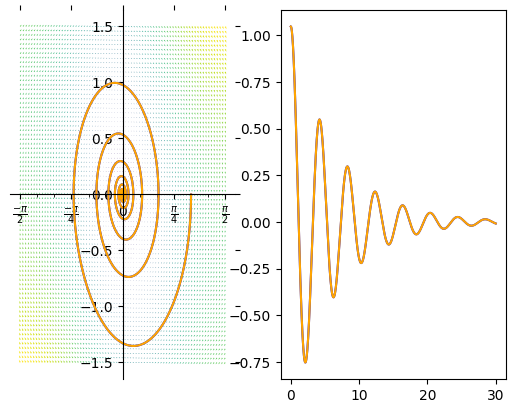

In [20]:
# %matplotlib tk
fig, (ax_phase, ax_time) = plt.subplots(nrows=1, ncols=2)

# Lots of plot formatting
# https://stackoverflow.com/a/31558968
# https://stackoverflow.com/a/34711742

# Move left y-axis and bottom x-axis to (0,0)
ax_phase.spines['left'].set_position('zero')
ax_phase.spines['bottom'].set_position('zero')

# Eliminate upper and right axes
ax_phase.spines['right'].set_visible(False)
ax_phase.spines['top'].set_visible(False)

# Show ticks in the left and lower axes only
ax_phase.xaxis.set_tick_params(bottom='on', top='off')
ax_phase.yaxis.set_tick_params(left='on', right='off')

# Multiples of pi for theta
# https://stackoverflow.com/a/53586826
def multiple_formatter(denominator=4, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

ax_phase.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax_phase.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax_phase.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

# Draw phase space velocity arrows
ax_phase.quiver(X, Y, U, V, M)
# Draw path through phase space
T = 30
_, thetas_eu, theta_dots_eu = theta_euler(T)
ax_phase.plot(thetas_eu, theta_dots_eu, color="blue")
_, thetas_rk, theta_dots_rk = theta_runge_kutta(T)
ax_phase.plot(thetas_rk, theta_dots_rk, color="orange")

ax_time.plot(np.arange(0, T, DELTA), thetas_eu[:-1], color="blue")
_ = ax_time.plot(np.arange(0, T, DELTA), thetas_rk[:-1], color="orange")
